[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-blue?logo=google-colab)](https://colab.research.google.com/github/csoneira/CFD_lesson/blob/main/CFD_notebook.ipynb)

# Timing using Threshold and Constant Fraction Discriminator (CFD)

This notebook explores and compares two popular techniques for extracting timing information from detector signals:
- **Threshold crossing**, which is simple but affected by amplitude-dependent time shifts (a.k.a. time walk).

- **Constant Fraction Discriminator (CFD)**, which reduces amplitude dependence and improves timing precision.

We simulate pairs of Gaussian pulses with varying amplitudes and delays to show how these methods perform and compare them statistically.

## Introduction

In radiation detectors (e.g., PET, particle physics), extracting the **time of arrival** of a signal is crucial for applications like coincidence detection and time-of-flight measurements.

However, using a **fixed amplitude threshold** to determine timing can lead to **time walk**, where higher amplitude signals cross the threshold earlier even if they arrived later.

To mitigate this, the **Constant Fraction Discriminator (CFD)** method finds the time when a signal crosses a fixed fraction of its amplitude **after subtracting a delayed copy** of the signal. This zero-crossing is less sensitive to amplitude variations.

In this notebook, we:
- Simulate Gaussian signals with different amplitudes and delays.

- Apply threshold and CFD methods to extract timing.

- Compare the accuracy and precision of both approaches.

- Visualize the results to understand the benefits of CFD.

### 📦 Import Libraries

We start by importing the necessary Python libraries:

- `numpy` for numerical operations,
- `matplotlib.pyplot` for plotting,
- `Polynomial` from `numpy.polynomial` for curve fitting,
- `norm` from `scipy.stats` to fit and analyze Gaussian distributions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import norm

### Simulation Parameters

We define the core simulation parameters:

- `num_samples`: Number of time points used to discretize the signal.
- `t`: The time array over which the signals are generated.
- `thresh`: The fixed amplitude threshold used for the threshold crossing method.

In [ ]:
# Parameters
num_samples = 10000
t = np.linspace(-10, 10, num_samples)
thresh = 0.2  # Threshold for crossing

### Signal Processing Functions

These functions are used to generate signals and extract timing information:

- `generate_signal`: Creates a Gaussian-shaped signal with a given amplitude, delay, and a randomly sampled width (`sigma`) to simulate pulse shape variability.

- `calculate_threshold_crossing`: Returns the first time point at which the signal crosses a fixed threshold, simulating a basic threshold-based timing method.

- `apply_cfd`: Implements the Constant Fraction Discriminator (CFD) algorithm by subtracting a delayed version of the signal from a scaled version of itself to find the zero-crossing time, which is more robust against amplitude variations.

In [ ]:
def generate_signal(amplitude, delay, t):
    """Generate a Gaussian signal with given amplitude, delay, and standard deviation."""
    sigma = np.random.uniform(0.9, 1.1)
    return amplitude * np.exp(-((t - delay) ** 2) / (2 * sigma ** 2))

def calculate_threshold_crossing(signal, t, threshold):
    """Find the time where the signal crosses a given threshold."""
    indices = np.where(signal >= threshold)[0]
    return t[indices[0]] if indices.size > 0 else None

def apply_cfd(signal, t, alpha, tau):
    """Apply Constant Fraction Discriminator (CFD) to a signal."""
    delayed_signal = np.interp(t - tau, t, signal, left=0, right=0)
    cfd_signal = alpha * signal - delayed_signal
    crossing_idx = np.where(cfd_signal < -0.001)[0]
    return t[crossing_idx[0]] if crossing_idx.size > 0 else None

### 🚀 Simulation: Comparing Threshold and CFD Timing

This function simulates and compares two timing extraction techniques using synthetic Gaussian signals:

1. **Signal Setup**:
   - A fixed reference signal (`A1 = 1.0`) is generated.

   - A second signal is generated with varying amplitude (`A2`) and a random time delay.

   - Both signals undergo timing extraction using two methods:
     - **Fixed Threshold Crossing**.
     - **Constant Fraction Discriminator (CFD)**.

2. **Data Collection**:
   - Time differences between signals are computed for both methods.

   - In threshold-based timing, the delay is corrected using a polynomial fit to the amplitude ratio `A2/A1`.

3. **Visualization**:
   - Side-by-side plots illustrate raw signals, timing extraction points, and 2D hexbin plots for density.

   - CFD signals are also shown to visualize their zero-crossings.
   
   - Final histograms compare the statistical distributions (mean and standard deviation) of the corrected threshold method and CFD.

4. **Performance Metric**:
   - The ratio of timing resolution (standard deviation σ) between CFD and corrected threshold is computed to quantify the improvement in precision.

In [2]:
def simulation():
    A1 = 1.0  # Fixed amplitude
    A2_values = np.linspace(1, 10, 10000)  # Amplitude for the second signal
    delays = np.random.uniform(0, 5, size=len(A2_values))  # Random delays

    alpha1, alpha2 = 0.8, 0.8  # Amplification factors for CFD
    tau1, tau2 = 0.5, 0.5  # Delays for CFD

    ratio_A2_A1 = []
    delta_t_th = []
    delta_t_cfd = []

    for A2, delay in zip(A2_values, delays):
        signal1 = generate_signal(A1, 0, t)
        signal2 = generate_signal(A2, delay, t)

        t_th1 = calculate_threshold_crossing(signal1, t, thresh)
        t_th2 = calculate_threshold_crossing(signal2, t, thresh)

        if t_th1 is not None and t_th2 is not None:
            ratio_A2_A1.append(A2 / A1)
            delta_t_th.append(t_th2 - t_th1 - delay)

            # Apply CFD
            t_cfd1 = apply_cfd(signal1, t, alpha1, tau1)
            t_cfd2 = apply_cfd(signal2, t, alpha2, tau2)

            if t_cfd1 is not None and t_cfd2 is not None:
                delta_t_cfd.append(t_cfd2 - t_cfd1 - delay)

        # Plot results
        
    # Fit a polynomial to the threshold crossing data
    poly = Polynomial.fit(ratio_A2_A1, delta_t_th, deg=2)
    corrected_delta_t_th = np.array(delta_t_th) - poly(np.array(ratio_A2_A1))
    
    # Plot results
    plt.figure(figsize=(18, 9))

    # Plot signals for debugging
    plt.subplot(2, 3, 1)
    plt.plot(t, signal1, label="Signal 1")
    plt.plot(t, signal2, label="Signal 2")
    plt.axhline(thresh, color='r', linestyle='--', label="Threshold")
    plt.title("Original Signals")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()

    # Threshold crossings
    plt.subplot(2, 3, 2)
    plt.scatter(ratio_A2_A1, delta_t_th, label="Threshold Crossing", s=1)
    plt.plot(ratio_A2_A1, poly(np.array(ratio_A2_A1)), '-', label="Polynomial Fit", color='orange', linewidth=2)
    plt.xlabel("A2 / A1")
    plt.ylabel("t_th2 - t_th1")
    plt.title("Threshold Crossing Time Differences")
    plt.grid()
    plt.legend()

    # Add 2D hexbin plot for threshold crossing differences
    plt.subplot(2, 3, 3)
    plt.hexbin(ratio_A2_A1, delta_t_th, gridsize=100, cmap='turbo')
    plt.colorbar(label="Counts")
    plt.xlabel("A2 / A1")
    plt.ylabel("t_th2 - t_th1")
    plt.title("2D Hexbin of Threshold Crossing")

    # Plot CFD signals for debugging
    cfd_signal1 = alpha1 * signal1 - np.interp(t - tau1, t, signal1, left=0, right=0)
    cfd_signal2 = alpha2 * signal2 - np.interp(t - tau2, t, signal2, left=0, right=0)
    plt.subplot(2, 3, 4)
    plt.plot(t, cfd_signal1, label="CFD Signal 1")
    plt.plot(t, cfd_signal2, label="CFD Signal 2")
    plt.axhline(0, color='r', linestyle='--', label="Zero Crossing")
    plt.title("CFD Signals")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()

    # CFD crossings
    plt.subplot(2, 3, 5)
    plt.scatter(ratio_A2_A1, delta_t_cfd, label="CFD Crossing", s=1)
    plt.xlabel("A2 / A1")
    plt.ylabel("t_cfd2 - t_cfd1")
    plt.title("CFD Crossing Time Differences")
    plt.grid()
    plt.legend()

    # Add 2D hexbin plot for CFD crossing differences
    plt.subplot(2, 3, 6)
    plt.hexbin(ratio_A2_A1, delta_t_cfd, gridsize=100, cmap='turbo', extent=[min(ratio_A2_A1), max(ratio_A2_A1), min(delta_t_th), max(delta_t_th)])
    plt.colorbar(label="Counts")
    plt.xlabel("A2 / A1")
    plt.ylabel("t_cfd2 - t_cfd1")
    plt.title("2D Hexbin of CFD Crossing")

    plt.tight_layout()
    plt.show()

    # Fit Gaussian to the data
    mu_corr, sigma_corr = norm.fit(corrected_delta_t_th)
    mu_cfd, sigma_cfd = norm.fit(delta_t_cfd)
    
    # Compute the ratio of sigma values
    sigma_ratio = (sigma_cfd / sigma_corr) * 100
    
    # Plot histograms
    plt.figure(figsize=(14, 10))
    bins = 100
    plt.hist(corrected_delta_t_th, bins=bins, alpha=0.7, label="Corrected Non-CFD", density=True)
    plt.hist(delta_t_cfd, bins=bins, alpha=0.7, label="CFD", density=True)
    
    # Add Gaussian fit lines
    x_corr = np.linspace(min(corrected_delta_t_th), max(corrected_delta_t_th), 1000)
    x_cfd = np.linspace(min(delta_t_cfd), max(delta_t_cfd), 1000)
    
    plt.plot(x_corr, norm.pdf(x_corr, mu_corr, sigma_corr), label=f"Non-CFD Fit: μ={mu_corr:.2f}, σ={sigma_corr:.2f}")
    plt.plot(x_cfd, norm.pdf(x_cfd, mu_cfd, sigma_cfd), label=f"CFD Fit: μ={mu_cfd:.2f}, σ={sigma_cfd:.2f}")
    
    # Add sigma ratio to legend
    plt.legend(title=f"$\\sigma_{{\\mathrm{{CFD}}}} / \\sigma_{{\\mathrm{{Non-CFD}}}}$: {sigma_ratio:.2f}%")
    
    plt.xlabel("Time Difference / AU")
    plt.ylabel("Counts")
    plt.title("Histograms of Corrected vs CFD Time Differences")
    plt.show()

### ▶️ Run the Simulation

We now execute the simulation to generate synthetic signals, apply both timing extraction methods, and visualize the results.

This cell runs all previously defined code and displays the final plots and statistical comparison between threshold and CFD timing.

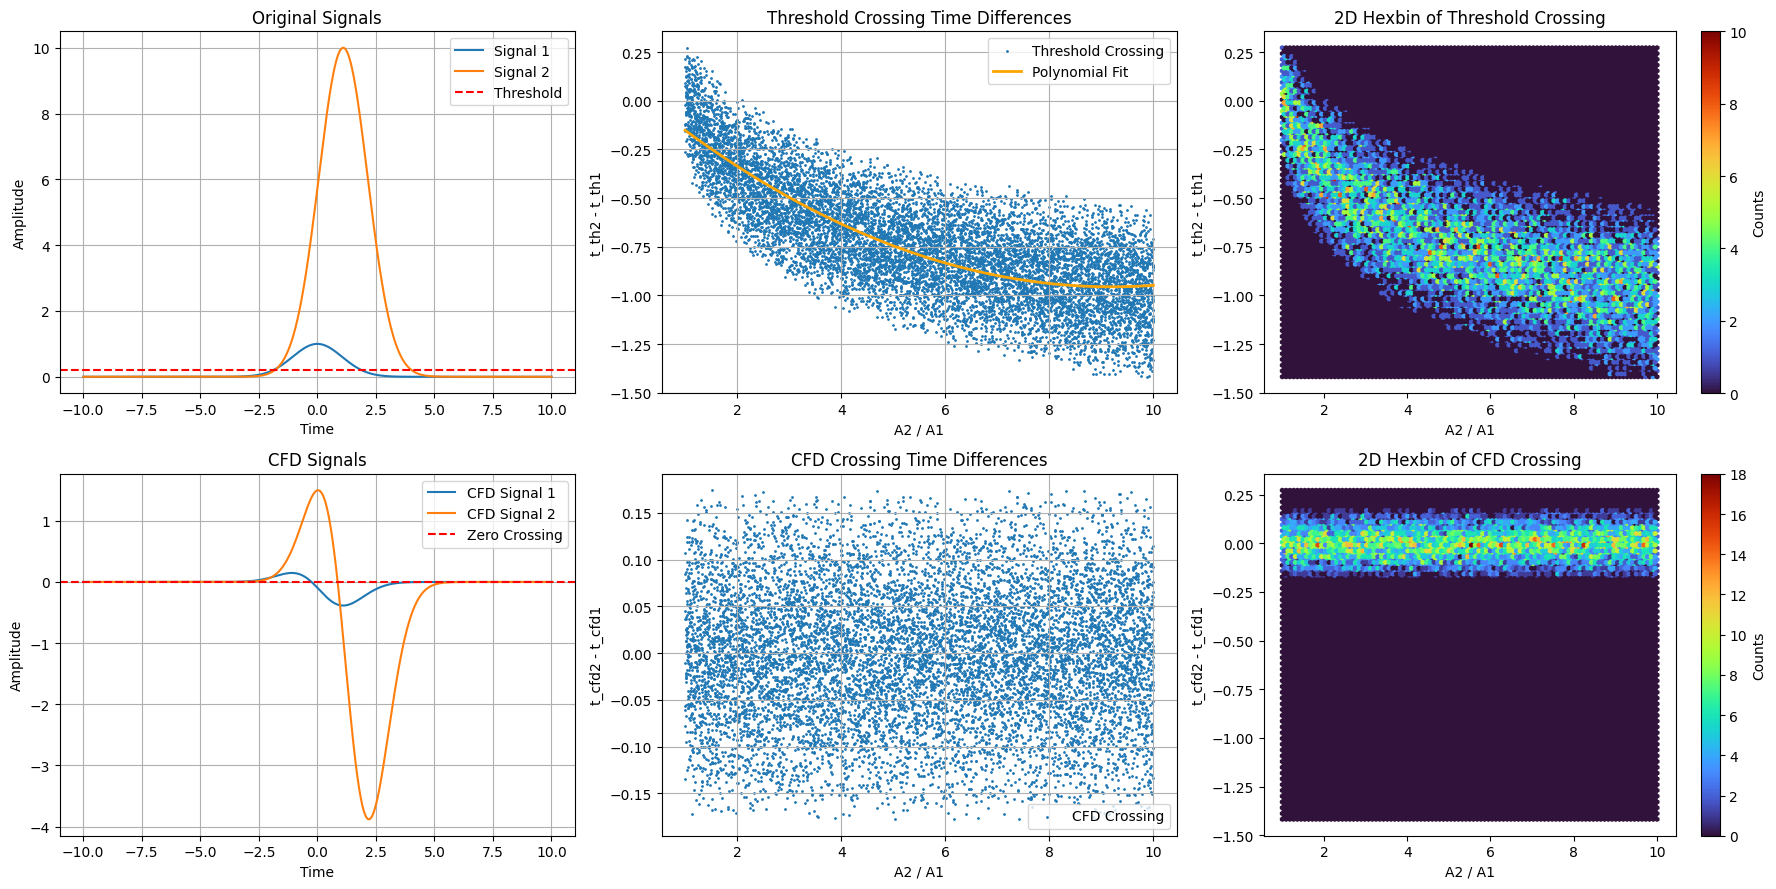

NameError: name 'norm' is not defined

In [3]:
simulation()

## ✅ Conclusion

In this notebook, we explored two timing extraction techniques:

- **Threshold crossing**: Simple and commonly used, but sensitive to signal amplitude variations. This leads to time walk, which we demonstrated and corrected using a polynomial fit.

- **Constant Fraction Discriminator (CFD)**: More sophisticated and robust, as it naturally compensates for amplitude differences by focusing on the signal's shape rather than absolute values.

We observed that:
- CFD significantly improves timing resolution.

- The histogram of CFD-corrected time differences is narrower and more centered compared to the threshold method.

- The ratio of standard deviations quantitatively confirms CFD's superior precision.

These techniques are essential in fields such as **PET imaging**, **nuclear instrumentation**, and **particle detectors**, where precise timing plays a critical role 🥺